In [22]:
from scipy import integrate
import matplotlib.pyplot as plt
import os
import numpy as np
from matplotlib import pyplot as plt      
import pandas as pd
from scipy import special                 
import array
import scipy as sp
import scipy.interpolate
import re
import pickle as pickle
def unPackRawFile(raw_path):
    """
    - unpacks the .raw file. Not used for the neural network.
    """
    y = np.loadtxt(raw_path, skiprows=6)
    distance = y[:,0]
    pec_vel = y[:,1]
    temp = y[:,2]
    HI_density = y[:,3]

    return distance, pec_vel, temp, HI_density

def getPos(path_LOS,linenumber=8):
    """
    the start position of the LOS is given inside each file, (in the comments)
    this function parses the comments to get that information
    """
    f = open(path_LOS)
    x = f.readlines()[linenumber]
    answer = re.search('\(([^)]+)', x).group(1)
    arr = np.array(answer.split(','),dtype=float)
    return arr

def getDir(path_LOS,linenumber=8):
    """
    the direction of the LOS is given inside each file, (in the comments)
    this function parses the comments to get that information
    """
    f = open(path_LOS)
    x = f.readlines()[linenumber]
    answer = re.search('\(([^)]+)', x.split(', ')[1]).group(1)
    arr = np.array(answer.split(','),dtype=float)
    return arr


def convertSphereToCart(theta, phi):
    "converts a unit vector in spherical to cartesian, needed for getGalaxies"
    return np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)])

In [23]:
def change_to_redshift(distance,redshift):
    '''change Cmpc to redshift, start at the redshift of the box'''
    distance_redshift = []
    distance_redshift.append(redshift)
    distance_difference = redshift
    for i in range(len(distance)-1):
        distance_difference -= (distance[i+1] - distance[i]) / 100 * .20
        distance_redshift.append(distance_difference)
    return distance_redshift

In [24]:


raw_path = 'los.00' + '{0:03}'.format(0) +'.raw'
factor = 0.1590/0.68
distance, pec_vel, temp, HI_density = unPackRawFile(raw_path)
distance_redshift = change_to_redshift(distance,5.29)


In [25]:
distance_difference = 0
stuff = [0]
for i in range(len(distance)-1):
    distance_difference += (distance[i+1] - distance[i]) *3.086e+24/0.68*0.1453
    stuff.append(distance_difference)

In [26]:
distance_redshift = np.flip(distance_redshift)

This is to convert the original cmpc distance along the los to redshift values

todo: put labels

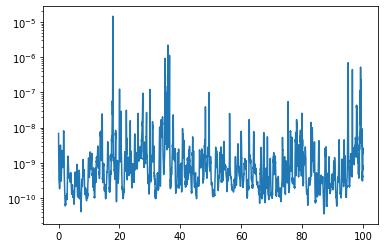

In [27]:
plt.plot(distance,HI_density)
'''add labels'''
plt.yscale("log")

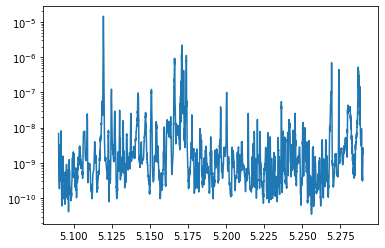

In [28]:
plt.plot(distance_redshift,HI_density)
plt.yscale("log")

In [29]:
def redshift_change(distance):
    '''find out how far the distance away is from the q912'''
    z_p = [0]
    distance_difference = 0
    for i in range(len(distance)-1):
        distance_difference += (distance[i +1 ] - distance[i])/100 * 0.23 
        z_p.append(distance_difference)
    return z_p

z_p = redshift_change(distance)

This is to convert the delta z from the original position of 5.88 (corresponding to z_qso)

In [30]:
print(z_p[0])
print(z_p[-1])

0
0.22997897800000638


Text(0, 0.5, 'log(HI)')

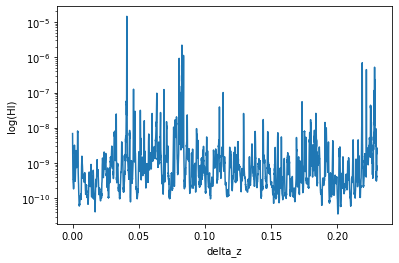

In [31]:
plt.plot(z_p,HI_density)
plt.yscale("log")
plt.xlabel('delta_z')
plt.ylabel("log(HI)")

We relate the opacity of our line of sight to the HI number density for cross section, $\sigma=6.3\times10^{-18}\mathrm{cm}^{2}$ as, 
$$
\kappa_{LL}=\sigma N_{HI}
$$
We can express the opacity $\kappa_{LL}$ in terms of its radial (position along the line-of-sight) and frequency dependence (which can be re-written in terms of a redshift dependence). $\kappa_{LL}$ evolves because of the decreasing frequency
(redshift) and also from changes to the physical conditions of the universe (e.g., the expanding proper distance). 
$$
\kappa_{LL}(r,\nu) = \tilde{\kappa}_{912}(r)\left(\frac{\nu}{\nu_{912}}\right)^{-3}
$$
Accounting for the redshift dependence of frequency, we can solve for $\tilde{\kappa}_{912}$,
$$
\tilde{\kappa}_{912}(z)=\kappa_{LL}\left(\frac{1+z}{1+z_{912}}\right)^{3}
$$

Therefore, we can express $\tilde{\kappa}_{912}$ in terms of redshift dependence and the HI number density,
$$
\kappa_{912}(z)=\sigma N_{HI} \left(\frac{1+z}{1+z_{912}}\right)^{3}  
$$

We can convert the cross section according to a similar redshift dependence,
$$
\sigma_{912} = \sigma\left(\frac{1+z}{1+z_{912}}\right)^3
$$

In [32]:
def change_sigma(redshift,distance_redshift):
    sigma = 6.3e-18
    new_sigma = np.multiply(sigma,np.power(((1+redshift)/(np.add(1,distance_redshift))),-3))
    return new_sigma

new_sigma = change_sigma(5.29,distance_redshift=distance_redshift)

In [33]:
new_sigma[-1]

6.3e-18

In [34]:
def integral(distance_redshift,HI_density,z_p,new_sigma):
    '''constants'''
    '''crosssectional area, cm^2'''
    sigma = 6.3e-18
    '''hubble constant km/s/mpc'''
    hubble_constant = 70
    '''km/s'''
    c = 300000
    '''Omega constant'''
    omega = 0.3
    '''HI is in cm^-3'''
    second_half = (np.power(np.add(1,z_p),-5.25))
    distance_change = 5.29
    HI_change  = []
    sigma_change = []
    redshift_change = []
    second_half_change = []
    tau = []
    value = []
    value2 = []
    for i in range(len(distance_redshift)):
        distance_change= distance_redshift[i] 
        redshift_change.append(z_p[i])
        HI_change.append(HI_density[i])
        sigma_change.append(new_sigma[i])
        second_half_change.append(second_half[i])
        integral = integrate.cumtrapz(np.multiply(np.multiply(HI_change,sigma_change),second_half_change),redshift_change,initial = 0)[-1]*3.08567758e24/10000
        value.append(integral)
        value2.append(c/(hubble_constant*omega**(1/2))*((1+distance_change)**2.75))
        tau.append(c/(hubble_constant*omega**(1/2))*((1+distance_change)**2.75* integral))
    return tau,value,value2

In [35]:
tau = []
for i in range(10):
    raw_path = 'los.00' + '{0:03}'.format(i) +'.raw'
    distance, pec_vel, temp, HI_density = unPackRawFile(raw_path)
    distance_redshift = change_to_redshift(distance,5.29)
    z_p = redshift_change(distance)
    new_sigma = change_sigma(5.29,distance_redshift)
    tau_value,value,value2 = integral(distance_redshift,HI_density,z_p,new_sigma)
    tau.append(tau_value)

In [36]:
def change_to_wavelength(redshift_distance,redshift):
    start_wavelength = 912
    wavelength = []
    for i in range(len(redshift_distance)):
        wavelength.append(912*(1+redshift_distance[i])/(1+redshift))
    return wavelength
y = []
for i in range(10):
    for z in tau[i]:
        y.append(z)
x = []
for i in range(10):
    raw_path = 'los.00' + '{0:03}'.format(i) +'.raw'
    distance, pec_vel, temp, HI_density = unPackRawFile(raw_path)
    distance_redshift = change_to_redshift(distance,5.29)
    wavelength = change_to_wavelength(distance_redshift,5.29)
    for p in wavelength:
        x.append(p)

In [37]:
len(x)

59719

In [42]:
z = np.polyfit(x, np.power(np.e,np.multiply(-1,y)), 4)

yn = np.poly1d(z)
yn(896)


0.34886825224384665

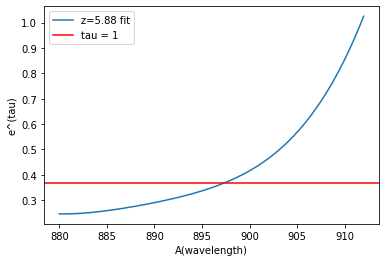

In [39]:
x_fit = np.linspace(880,912,1000)
plt.plot(x_fit,yn(x_fit),label = 'z=5.88 fit')
plt.axhline(y=0.367879, color='r', linestyle='-',label ="tau = 1")
plt.xlabel("A(wavelength)")
plt.ylabel("e^(tau)")
plt.legend()